# **The Age of Recommender Systems**

The continuos growth in tha data has led to a new era of information.Now a days data is being used to create more efficient system and this si where Recommendation systems come into play.

Recommendation system are a type of **information filtering system** as they help to improve the quality of search result and provides items that are more relevant to the search item or are related to the search history of the user.

> *  **Content Based Filtering**- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

Loading the important library

In [ ]:
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import warnings
warnings.simplefilter("ignore")

Loading the datasets

1st and 2nd datasets contains same amount of data

In [ ]:
credits = pd.read_csv('datasets/tmdb_5000_credits.csv')
movies = pd.read_csv('datasets/tmdb_5000_movies.csv')


The first dataset contains the following features:-

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:- 

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average -  average ratings the movie recieved.
* vote_count - the count of votes recieved.




the first and second dataset is divided but contains same field of data ont he basis of Id.

Movies dataset has Id and credits datset has id, so we just rename and merge these two datasets

In [ ]:
credit_renamed = credits.rename(index=str,columns={'movie_id':'id'})
movies_df = movies.merge(credit_renamed,on='id')


**just a peak at our data**

In [ ]:
movies_df.head()

In [ ]:
movies_df.columns

 Above we displayed all the columns availabel in dataset after merging 1st and second dataset
 But to create a content based recomendation system we only need some particular column,
 
 so, we just filter out two columns from all the datasets.


In [ ]:
movies_df1 = movies_df[{'original_title','overview'}]

In [ ]:
movies_df1.original_title = movies_df1.original_title.str.lower()

In [ ]:
movies_df1.shape

We import a library TfidfVectorizer,

because we have to convert all the content of the movie into Tf(Term-Frequency) and IDF(Inverse Document Frequency),
and along conversion we removed all the stopwords like:-the, by etc..

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'

tfv = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies_df1['overview'] = movies_df1['overview'].fillna('')

We perform the transformation on overview column, because that column has all the content of the movies.

In [ ]:
#Construct the required TF-IDF matrix by fitting and transforming the data

tfv_matrix = tfv.fit_transform(movies_df1['overview'])

After conversion we got a sparse matrix,

Assume general form: (A,B) C

A: Document index B: Specific word-vector index C: TFIDF score for word B in document A

In [ ]:
print(tfv_matrix[0])

In [ ]:
tfv_matrix.shape

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

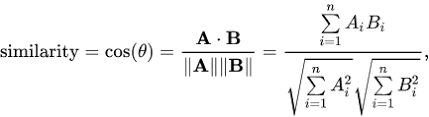


Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's sigmoid_kernel() instead of cosine_similarities() since it is faster.

In [ ]:
from sklearn.metrics.pairwise import sigmoid_kernel

sig = sigmoid_kernel(tfv_matrix,tfv_matrix)

In [ ]:
sig[0]

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [ ]:
indices = pd.Series(movies_df1.index,index=movies_df1['original_title']).drop_duplicates()

In [ ]:
sig[indices['avatar']]

Using pickle library we just saved all the sigmoid values, indices and title for the future use

In [ ]:
with open("movie_title.pickle","wb") as f:
    pickle.dump(movies_df1.original_title,f)
    
with open("sigmoid_kernel.pickle","wb") as f:
    pickle.dump(sig,f)
    
with open("indices.pickle","wb") as f:
    pickle.dump(indices,f)

In [ ]:
sorted(list(enumerate(sig[indices['avatar']])), key=lambda x:x[1],reverse=True)

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, sig=sig):
    try:
        # Get the index of the movie that matches the title
        title = title.lower()
    
        idx = indices[title]

         # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(sig[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        value = movies_df1['original_title'].iloc[movie_indices]
        value.reset_index(drop=True,inplace = True)
        value.index = value.index+1
        return value
    except:
        return 0

In [ ]:
get_recommendations('avatar')
